# TCAV Analysis: All Layers Comparison

Comparing **stem, stage0-5** layers to find which best captures speaker identity through acoustic concepts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
print("Ready!")

Ready!


In [2]:
# Load data
df = pd.read_csv('tcav_all_layers_results.csv')
print(f"Total rows: {len(df)}")
print(f"Layers: {df['layer_key'].unique()}")
print(f"Speakers: {df['true label'].unique()}")
print(f"Concepts: {df['concept name'].nunique()}")

Total rows: 8820
Layers: ['stem' 'stage0' 'stage1' 'stage2' 'stage3' 'stage4' 'stage5']
Speakers: ['eden' 'idan' 'yoav']
Concepts: 14


In [3]:
# Filter correct predictions only
df = df[df['true label'] == df['predicted label']]
print(f"After filtering correct predictions: {len(df)} rows")

After filtering correct predictions: 8820 rows


In [4]:
# Prepare data per layer
def get_layer_data(df, layer):
    layer_df = df[df['layer_key'] == layer]
    vector_df = layer_df.pivot_table(
        index=['path', 'true label'],
        columns='concept name',
        values='magnitude'
    ).reset_index()
    concept_cols = [c for c in vector_df.columns if c not in ['path', 'true label']]
    X = vector_df[concept_cols].values
    y = vector_df['true label'].values
    return X, y, concept_cols, vector_df

layers = ['stem', 'stage0', 'stage1', 'stage2', 'stage3', 'stage4', 'stage5']
layer_data = {}
for layer in layers:
    X, y, concepts, vector_df = get_layer_data(df, layer)
    layer_data[layer] = {'X': X, 'y': y, 'concepts': concepts, 'df': vector_df}
    print(f"{layer}: {X.shape[0]} samples, {X.shape[1]} concepts")

stem: 90 samples, 14 concepts
stage0: 90 samples, 14 concepts
stage1: 90 samples, 14 concepts
stage2: 90 samples, 14 concepts
stage3: 90 samples, 14 concepts
stage4: 90 samples, 14 concepts
stage5: 90 samples, 14 concepts


---
# Section 1: Speaker-Concept Heatmaps per Layer

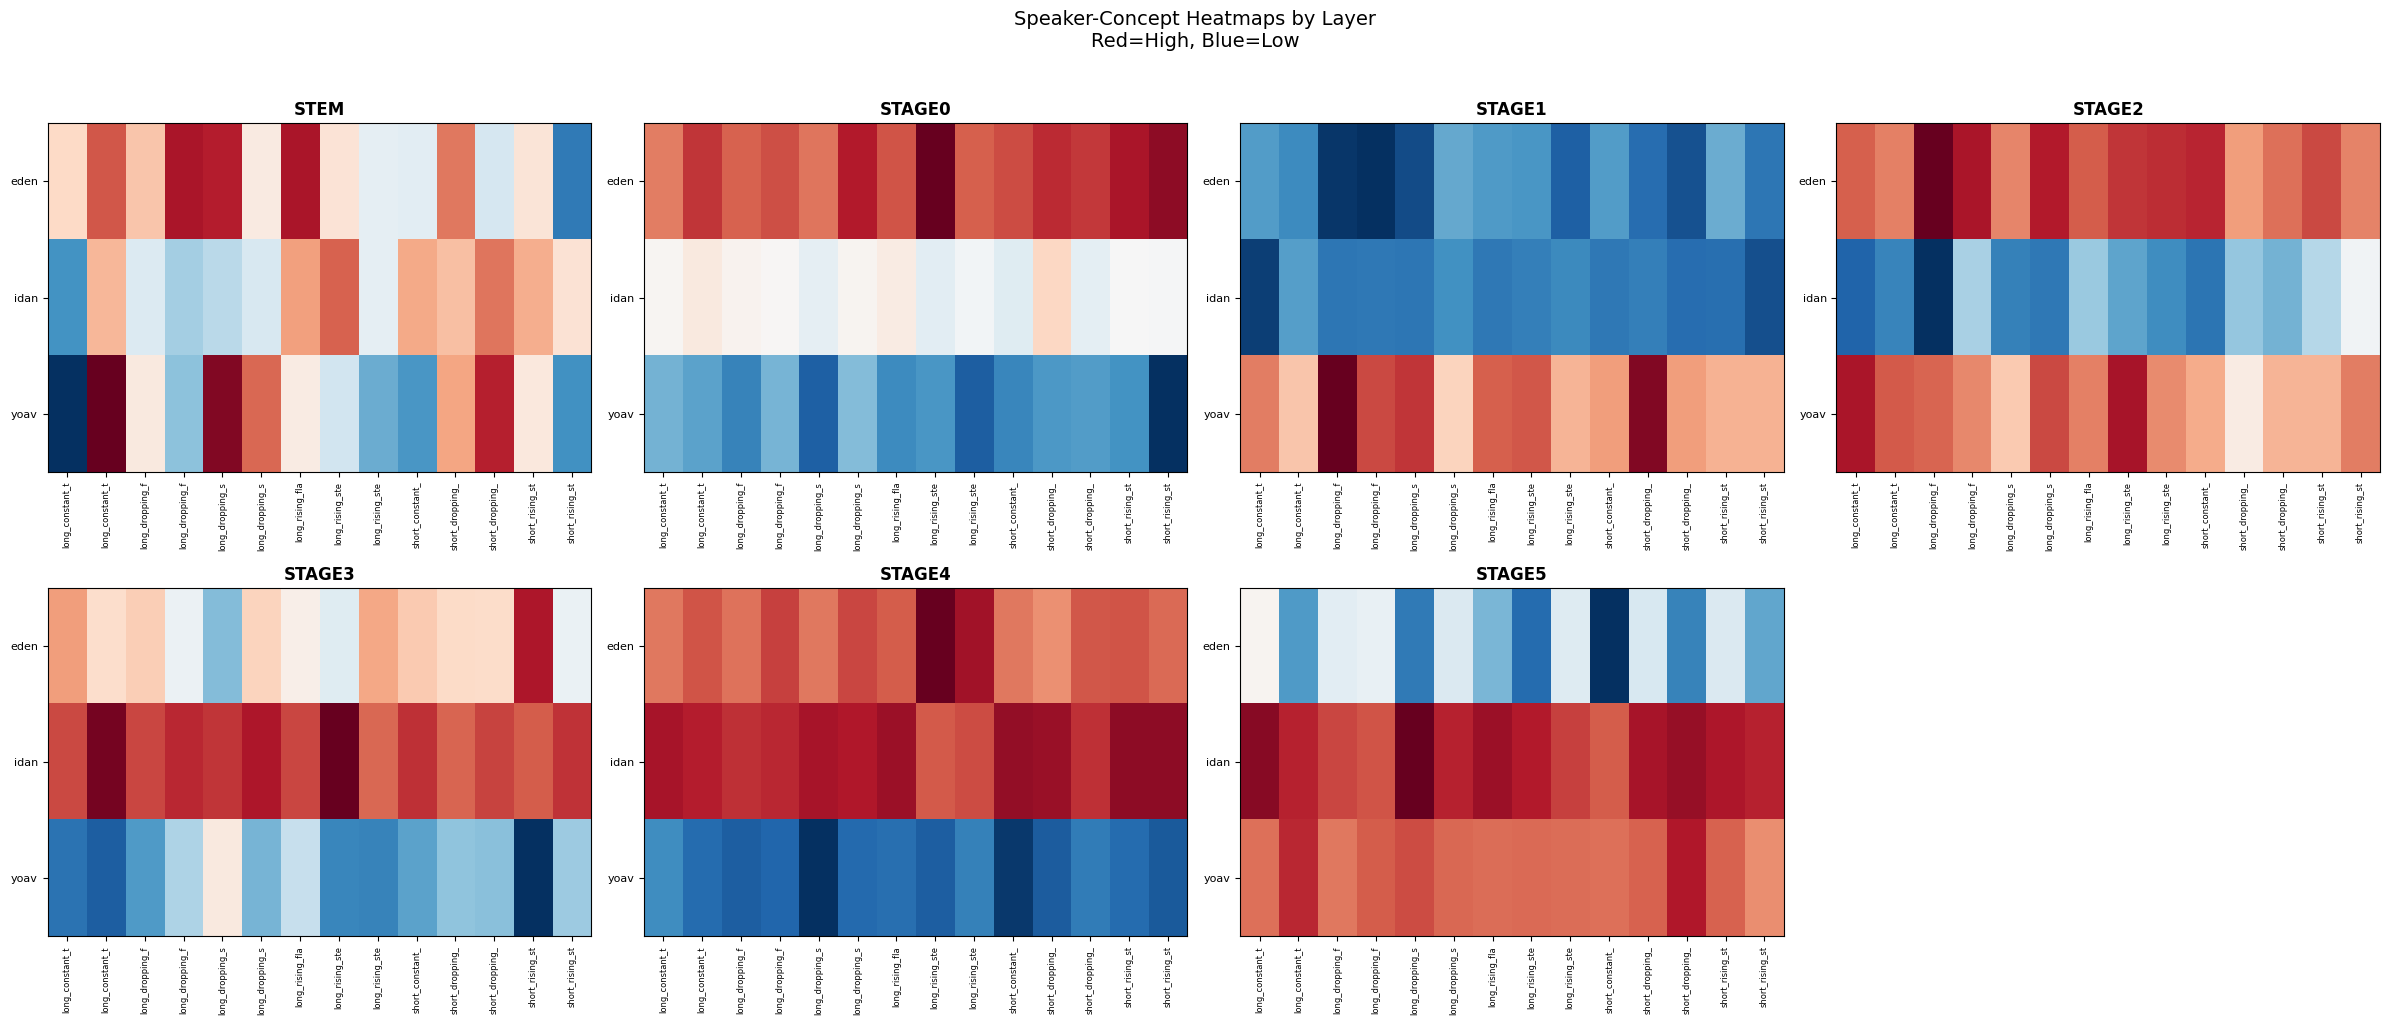

In [5]:
# Heatmaps for all layers
fig, axes = plt.subplots(2, 4, figsize=(24, 10))
axes = axes.flatten()

for idx, layer in enumerate(layers):
    vector_df = layer_data[layer]['df']
    table = vector_df.drop(columns=['path']).groupby('true label').mean()
    
    ax = axes[idx]
    im = ax.imshow(table.values, cmap='RdBu_r', aspect='auto')
    ax.set_xticks(np.arange(len(table.columns)))
    ax.set_yticks(np.arange(len(table.index)))
    ax.set_xticklabels([c[:15] for c in table.columns], fontsize=6, rotation=90)
    ax.set_yticklabels(table.index, fontsize=8)
    ax.set_title(f'{layer.upper()}', fontsize=12, fontweight='bold')

axes[-1].set_visible(False)  # Hide extra subplot
plt.suptitle('Speaker-Concept Heatmaps by Layer\nRed=High, Blue=Low', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('tcav/heatmaps_all_layers.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Section 2: PCA Visualization per Layer

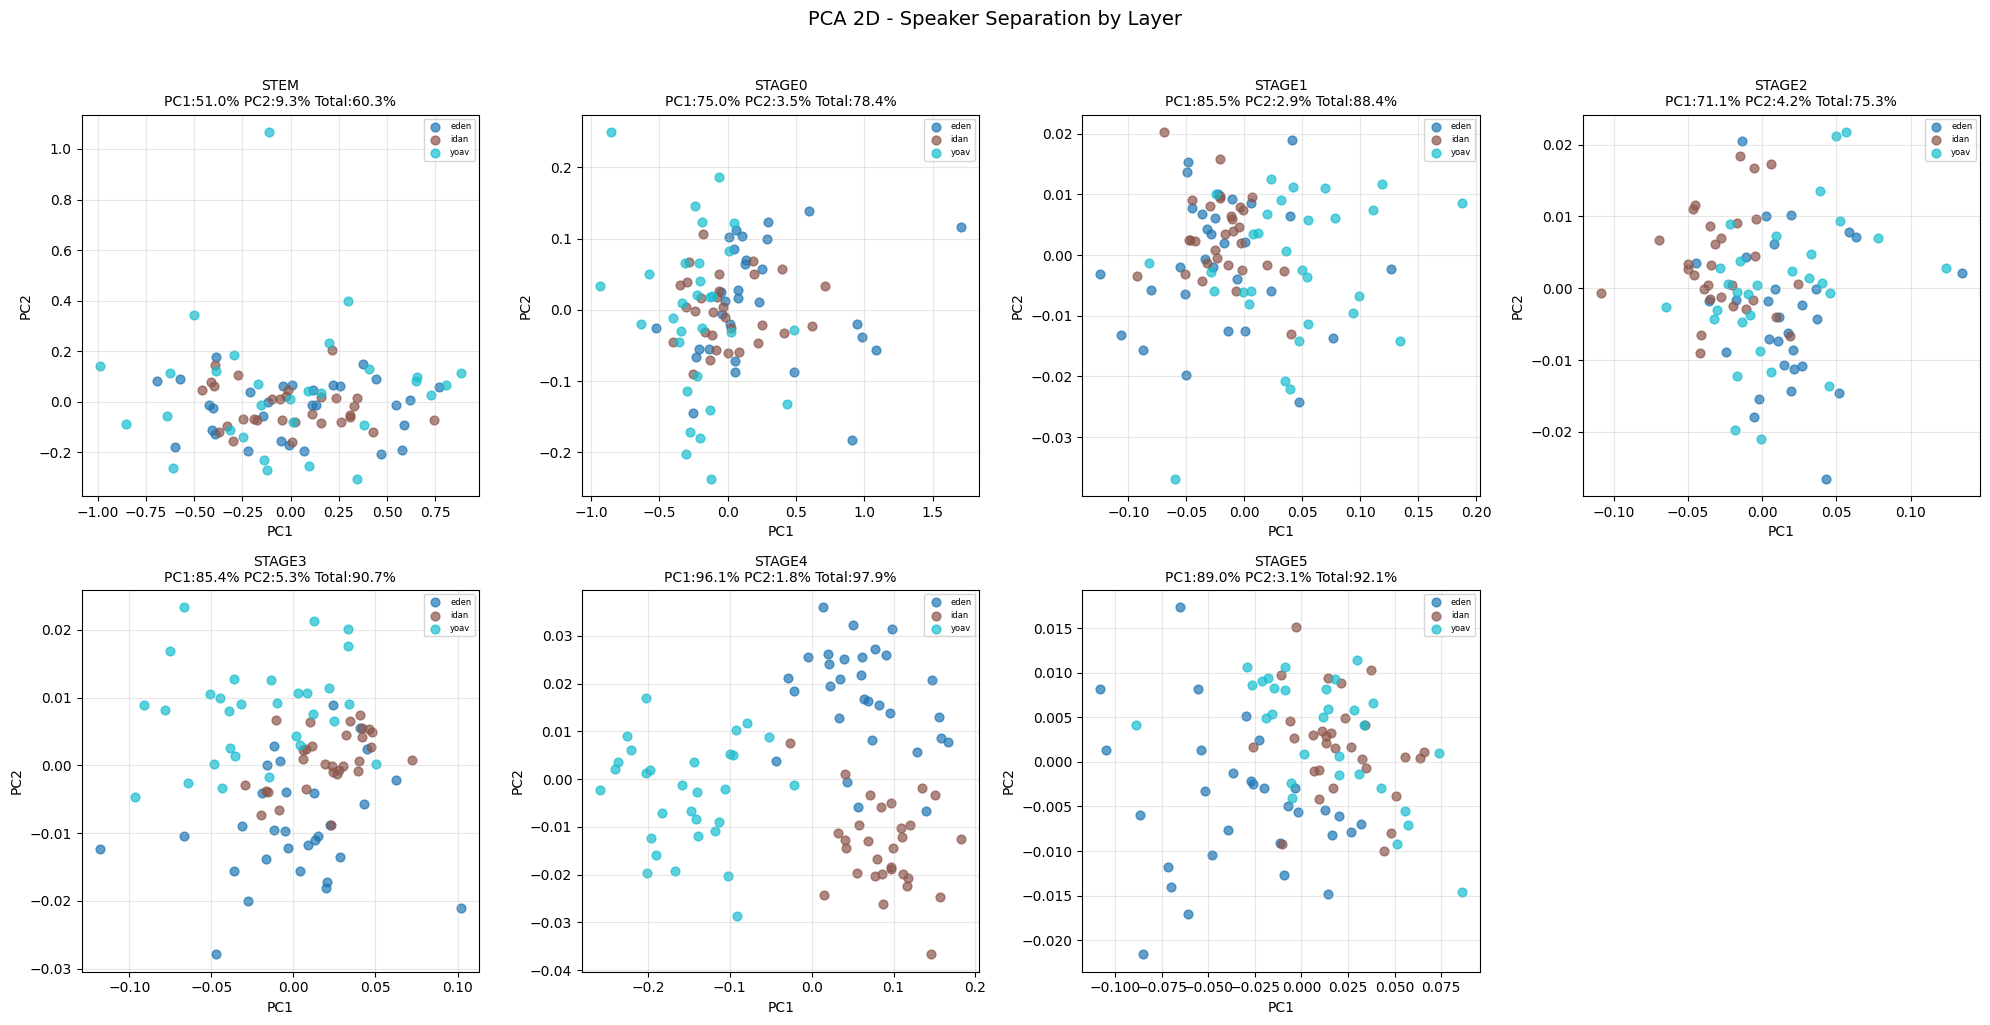

In [6]:
# PCA for all layers
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

pca_results = {}

for idx, layer in enumerate(layers):
    X = layer_data[layer]['X']
    y = layer_data[layer]['y']
    
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    evr = pca.explained_variance_ratio_
    pca_results[layer] = {'pca': pca, 'X_pca': X_pca, 'evr': evr}
    
    ax = axes[idx]
    labels = np.unique(y)
    colors = plt.cm.tab10(np.linspace(0, 1, len(labels)))
    
    for i, lbl in enumerate(labels):
        mask = y == lbl
        ax.scatter(X_pca[mask, 0], X_pca[mask, 1], c=[colors[i]], label=lbl, alpha=0.7, s=40)
    
    ax.set_title(f'{layer.upper()}\nPC1:{evr[0]*100:.1f}% PC2:{evr[1]*100:.1f}% Total:{evr.sum()*100:.1f}%', fontsize=10)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.legend(fontsize=6, loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_visible(False)
plt.suptitle('PCA 2D - Speaker Separation by Layer', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('tcav/pca_all_layers.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Section 3: Which Concepts Represent Each Speaker?

In [7]:
# Use STEM layer as example (you can change this)
example_layer = 'stem'
vector_df = layer_data[example_layer]['df']
speaker_table = vector_df.drop(columns=['path']).groupby('true label').mean()

print(f"=== TOP CONCEPTS PER SPEAKER ({example_layer.upper()}) ===\n")
for speaker in speaker_table.index:
    row = speaker_table.loc[speaker].sort_values(ascending=False)
    top3 = row.head(3)
    print(f"{speaker}: {', '.join([f'{c[:20]}({v:.2f})' for c,v in top3.items()])}")

=== TOP CONCEPTS PER SPEAKER (STEM) ===

eden: long_dropping_flat_t(0.01), long_rising_flat_thi(0.01), long_dropping_steep_(0.01)
idan: long_rising_steep_th(0.00), short_dropping_steep(0.00), long_rising_flat_thi(-0.00)
yoav: long_constant_thick_(0.02), long_dropping_steep_(0.02), short_dropping_steep(0.01)


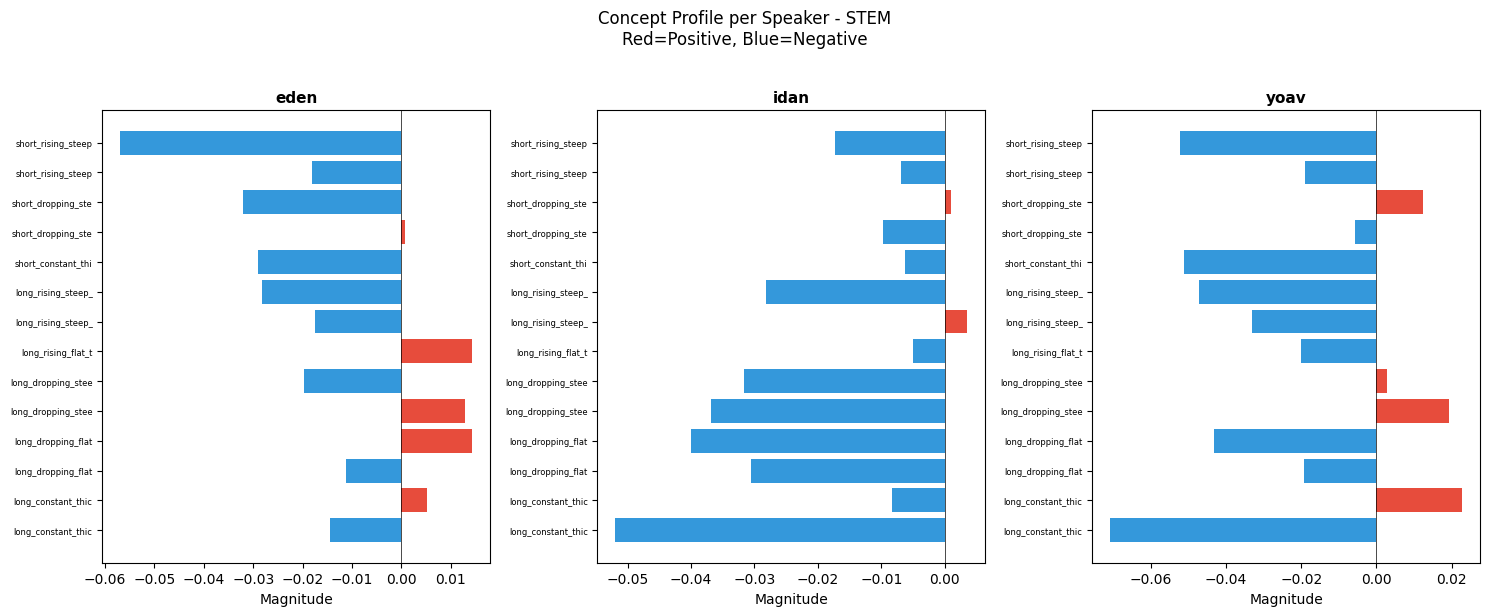

Saved: tcav/concept_profile_stem.png



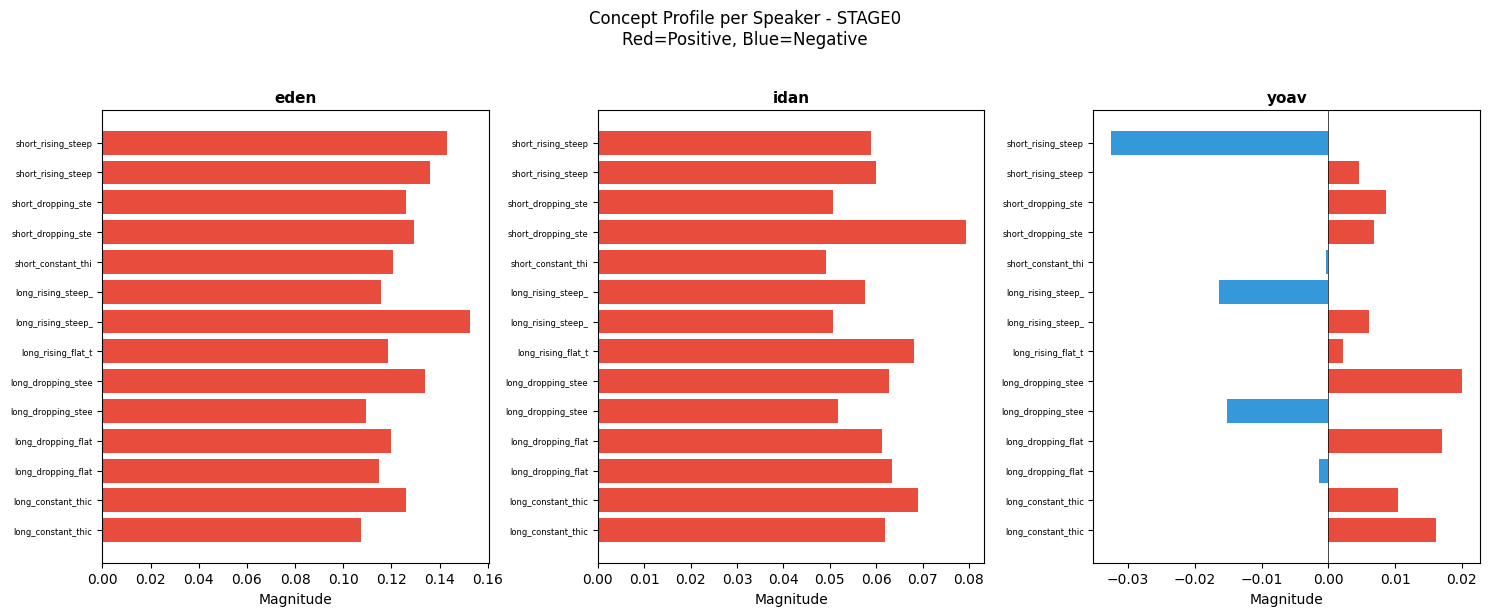

Saved: tcav/concept_profile_stage0.png



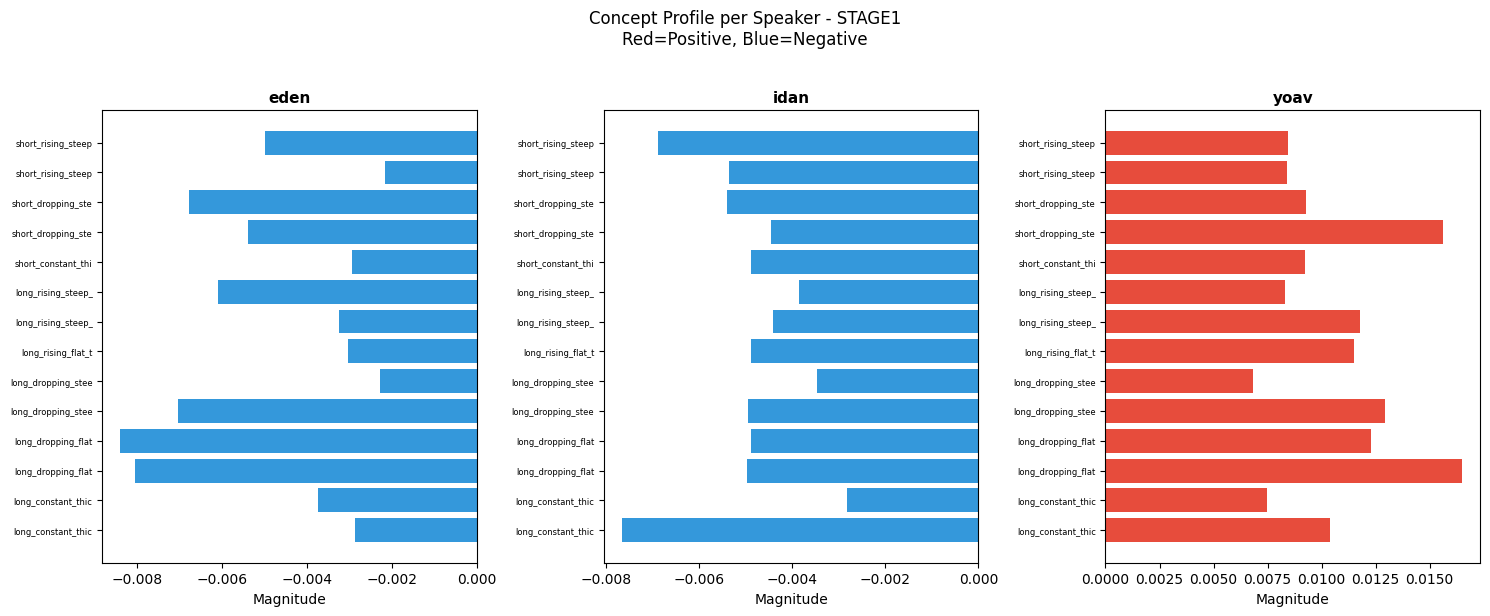

Saved: tcav/concept_profile_stage1.png



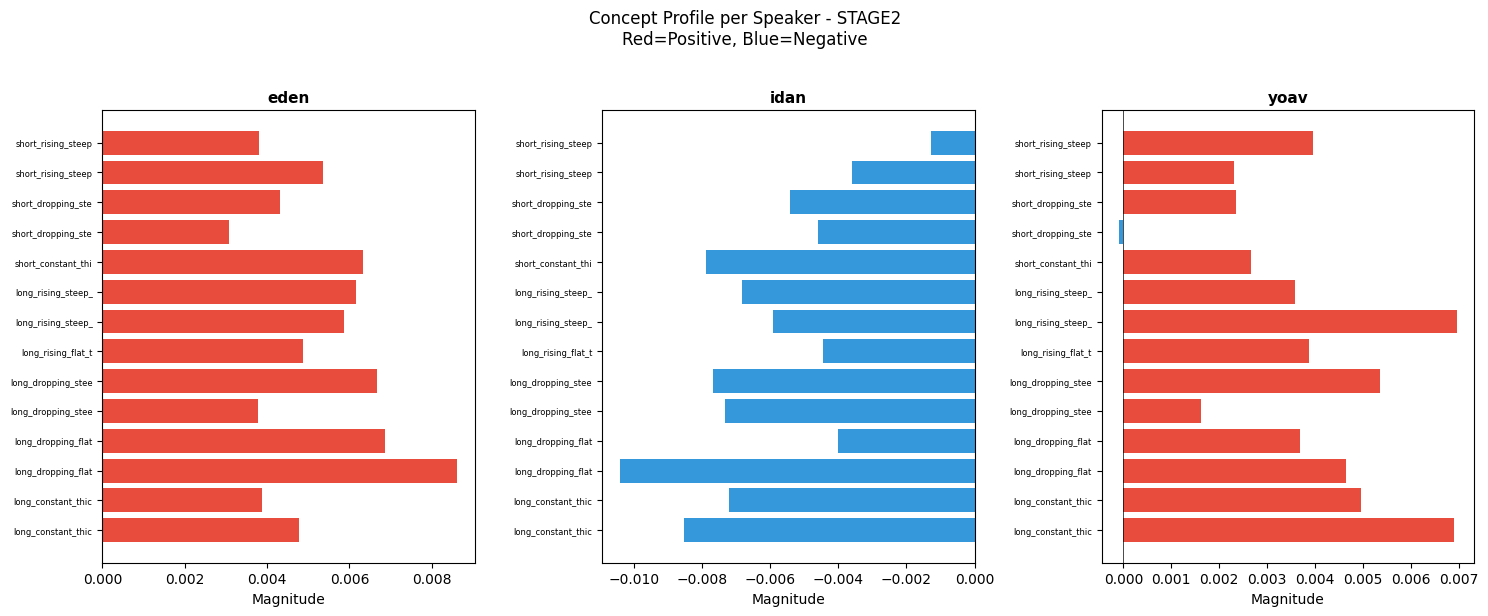

Saved: tcav/concept_profile_stage2.png



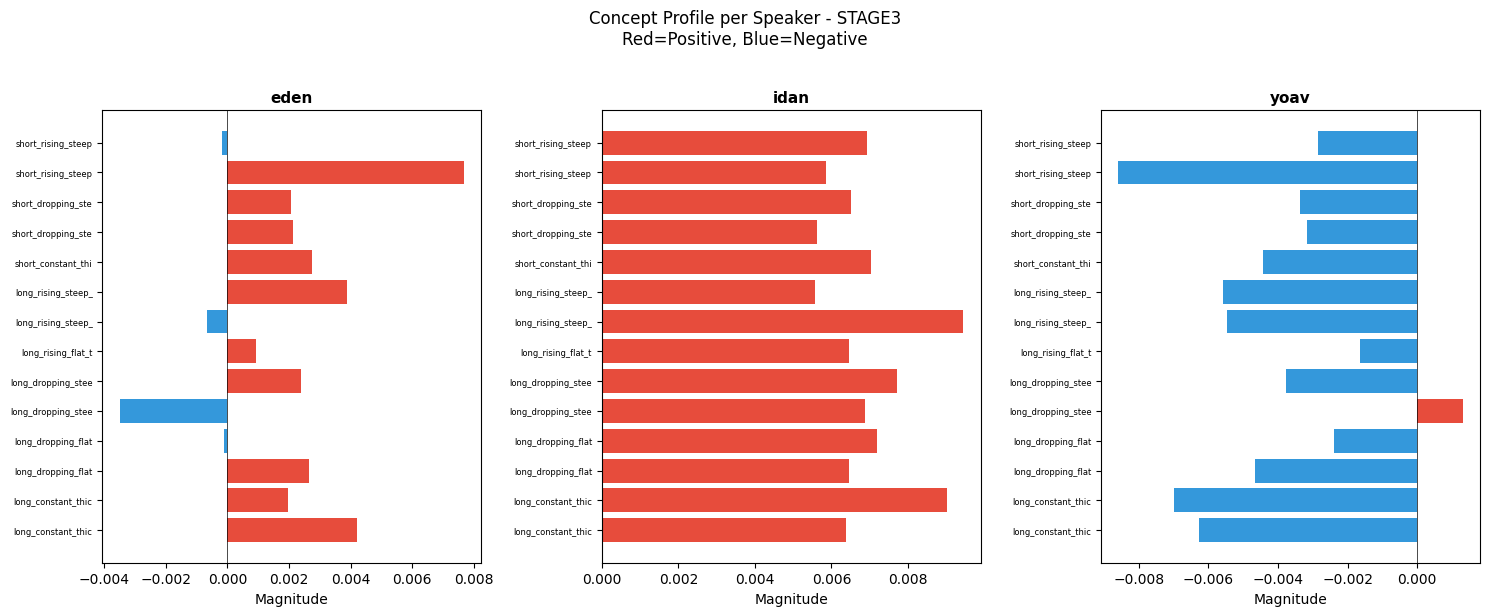

Saved: tcav/concept_profile_stage3.png



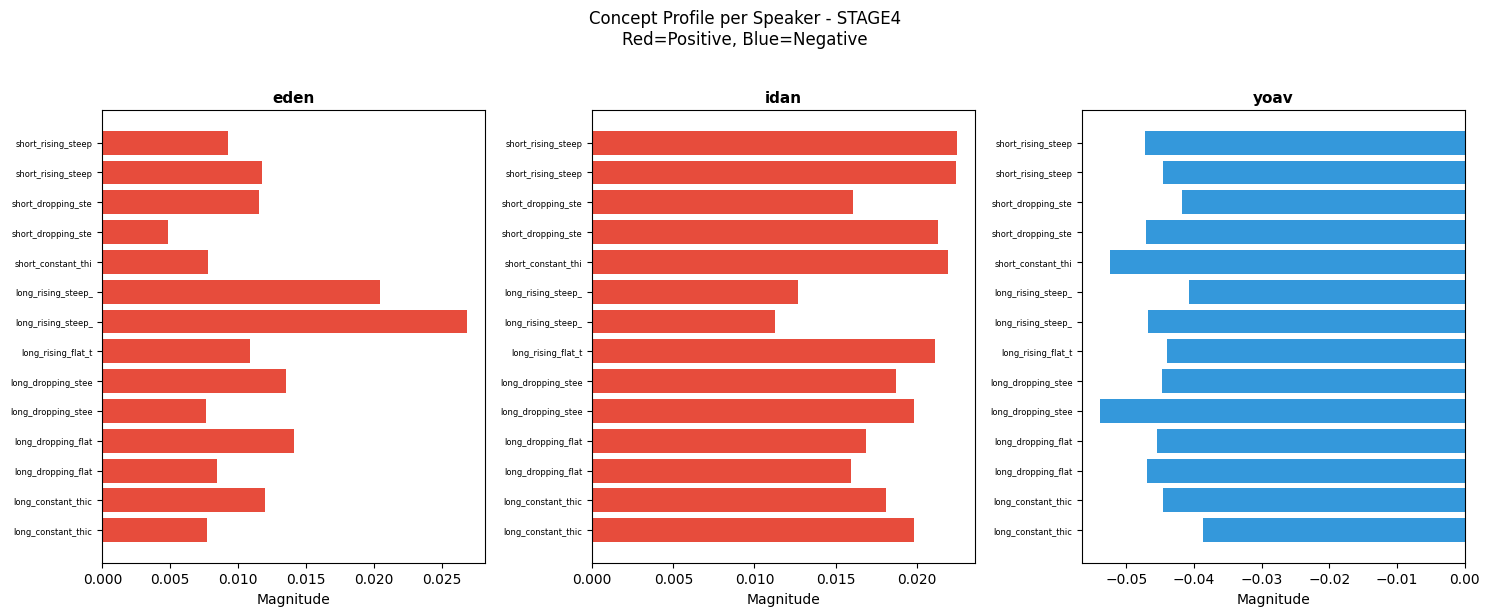

Saved: tcav/concept_profile_stage4.png



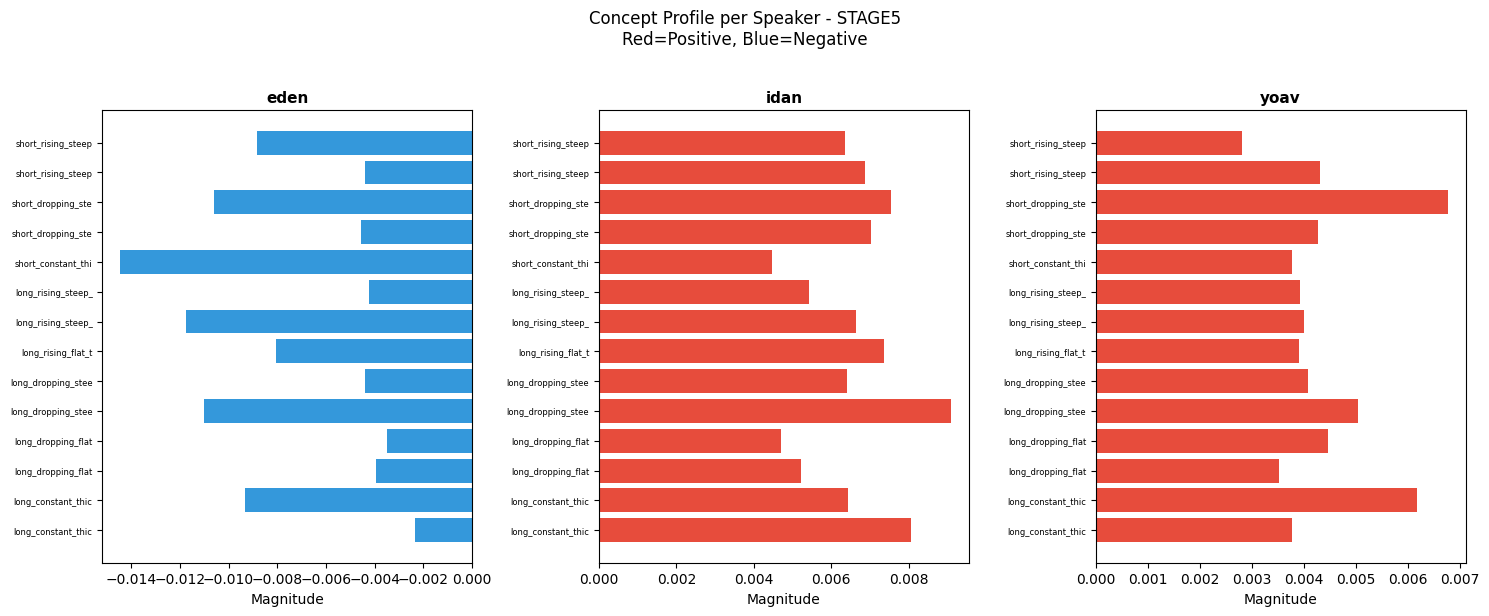

Saved: tcav/concept_profile_stage5.png



In [8]:
# Concept Profile per Speaker - ALL LAYERS
for layer in layers:
    vector_df = layer_data[layer]['df']
    speaker_table = vector_df.drop(columns=['path']).groupby('true label').mean()
    n_speakers = len(speaker_table.index)
    
    fig, axes = plt.subplots(1, n_speakers, figsize=(5*n_speakers, 6))
    if n_speakers == 1:
        axes = [axes]
    
    for idx, speaker in enumerate(speaker_table.index):
        ax = axes[idx]
        values = speaker_table.loc[speaker]
        colors = ['#e74c3c' if v > 0 else '#3498db' for v in values]
        ax.barh(range(len(values)), values.values, color=colors)
        ax.set_yticks(range(len(values)))
        ax.set_yticklabels([c[:18] for c in values.index], fontsize=6)
        ax.axvline(x=0, color='black', linewidth=0.5)
        ax.set_title(f'{speaker}', fontsize=11, fontweight='bold')
        ax.set_xlabel('Magnitude')
    
    plt.suptitle(f'Concept Profile per Speaker - {layer.upper()}\nRed=Positive, Blue=Negative', fontsize=12, y=1.02)
    plt.tight_layout()
    plt.savefig(f'tcav/concept_profile_{layer}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"Saved: tcav/concept_profile_{layer}.png\n")

In [9]:
# Which speaker owns each concept? (STAGE4 - Best Layer)
best_layer = 'stage4'
vector_df = layer_data[best_layer]['df']
speaker_table = vector_df.drop(columns=['path']).groupby('true label').mean()

print(f"=== CONCEPT OWNERSHIP ({best_layer.upper()} - BEST LAYER) ===\n")
ownership = {}
for concept in speaker_table.columns:
    top_speaker = speaker_table[concept].idxmax()
    top_value = speaker_table[concept].max()
    ownership[concept] = top_speaker
    print(f"{concept[:30]:32s} → {top_speaker} ({top_value:.3f})")

ownership_df = pd.DataFrame({'Concept': list(ownership.keys()), 'Top Speaker': list(ownership.values())})
print("\n")
ownership_df

=== CONCEPT OWNERSHIP (STAGE4 - BEST LAYER) ===

long_constant_thick              → idan (0.020)
long_constant_thick_Vibrato      → idan (0.018)
long_dropping_flat_thick         → idan (0.016)
long_dropping_flat_thick_Vibra   → idan (0.017)
long_dropping_steep_thick        → idan (0.020)
long_dropping_steep_thin         → idan (0.019)
long_rising_flat_thick           → idan (0.021)
long_rising_steep_thick          → eden (0.027)
long_rising_steep_thin           → eden (0.020)
short_constant_thick             → idan (0.022)
short_dropping_steep_thick       → idan (0.021)
short_dropping_steep_thin        → idan (0.016)
short_rising_steep_thick         → idan (0.022)
short_rising_steep_thin          → idan (0.022)




,Concept,Top Speaker
0,long_constant_thick,idan
1,long_constant_thick_Vibrato,idan
2,long_dropping_flat_thick,idan
3,long_dropping_flat_thick_Vibrato,idan
4,long_dropping_steep_thick,idan
5,long_dropping_steep_thin,idan
6,long_rising_flat_thick,idan
7,long_rising_steep_thick,eden
8,long_rising_steep_thin,eden
9,short_constant_thick,idan


---
# Section 4: Clustering Metrics - Layer Comparison

In [10]:
# Compute metrics for all layers
def compute_metrics(X, y):
    n_clusters = len(np.unique(y))
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    pred = kmeans.fit_predict(X)
    
    ari = adjusted_rand_score(y_enc, pred)
    sil = silhouette_score(X, pred, metric='cosine') if len(np.unique(pred)) > 1 else 0
    return {'ARI': ari, 'Silhouette': sil}

metrics = {}
for layer in layers:
    X = layer_data[layer]['X']
    y = layer_data[layer]['y']
    metrics[layer] = compute_metrics(X, y)

metrics_df = pd.DataFrame(metrics).round(4)
print("=== CLUSTERING METRICS BY LAYER ===")
metrics_df

=== CLUSTERING METRICS BY LAYER ===


,stem,stage0,stage1,stage2,stage3,stage4,stage5
ARI,-0.0112,0.1327,0.0651,0.1173,0.0952,0.4798,0.1064
Silhouette,0.2317,-0.1201,0.2189,0.2090,0.2935,0.3995,0.3911


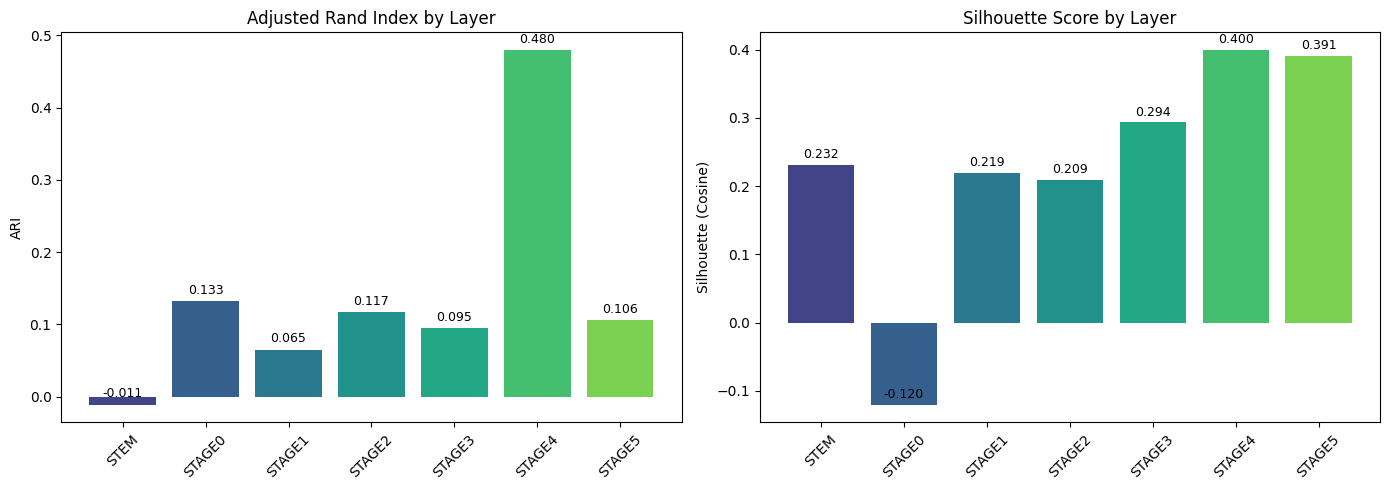

In [11]:
# Bar chart comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(layers))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(layers)))

# ARI
ari_vals = [metrics[l]['ARI'] for l in layers]
bars1 = axes[0].bar(x, ari_vals, color=colors)
axes[0].set_xticks(x)
axes[0].set_xticklabels([l.upper() for l in layers], rotation=45)
axes[0].set_ylabel('ARI')
axes[0].set_title('Adjusted Rand Index by Layer', fontsize=12)
for i, v in enumerate(ari_vals):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

# Silhouette
sil_vals = [metrics[l]['Silhouette'] for l in layers]
bars2 = axes[1].bar(x, sil_vals, color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels([l.upper() for l in layers], rotation=45)
axes[1].set_ylabel('Silhouette (Cosine)')
axes[1].set_title('Silhouette Score by Layer', fontsize=12)
for i, v in enumerate(sil_vals):
    axes[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('tcav/metrics_all_layers.png', dpi=150, bbox_inches='tight')
plt.show()

---
# Section 5: PCA Variance Comparison

In [12]:
# PCA variance by layer
pca_variance = {}
for layer in layers:
    evr = pca_results[layer]['evr']
    pca_variance[layer] = {'PC1': evr[0], 'PC2': evr[1], 'Total': evr.sum()}

pca_df = pd.DataFrame(pca_variance).T * 100
pca_df = pca_df.round(2)
print("=== PCA VARIANCE EXPLAINED (%) ===")
pca_df

=== PCA VARIANCE EXPLAINED (%) ===


,PC1,PC2,Total
stem,51.01,9.29,60.30
stage0,74.99,3.45,78.44
stage1,85.49,2.90,88.39
stage2,71.12,4.20,75.32
stage3,85.41,5.25,90.66
stage4,96.14,1.78,97.93
stage5,88.98,3.13,92.11


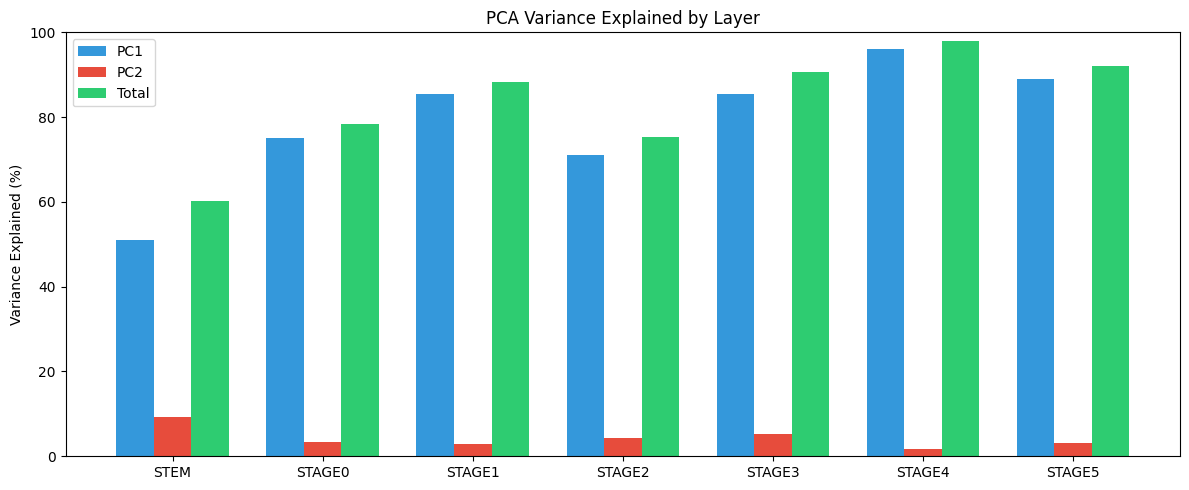

In [13]:
# Variance bar chart
fig, ax = plt.subplots(figsize=(12, 5))

x = np.arange(len(layers))
width = 0.25

ax.bar(x - width, pca_df['PC1'], width, label='PC1', color='#3498db')
ax.bar(x, pca_df['PC2'], width, label='PC2', color='#e74c3c')
ax.bar(x + width, pca_df['Total'], width, label='Total', color='#2ecc71')

ax.set_xticks(x)
ax.set_xticklabels([l.upper() for l in layers])
ax.set_ylabel('Variance Explained (%)')
ax.set_title('PCA Variance Explained by Layer')
ax.legend()
ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('tcav/pca_variance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
# FINAL SUMMARY

In [14]:
print("="*70)
print("                    FINAL SUMMARY                    ")
print("="*70)

# Best layer by ARI
best_ari_layer = max(metrics, key=lambda x: metrics[x]['ARI'])
best_ari = metrics[best_ari_layer]['ARI']

# Best layer by Silhouette
best_sil_layer = max(metrics, key=lambda x: metrics[x]['Silhouette'])
best_sil = metrics[best_sil_layer]['Silhouette']

# Best PCA variance
best_pca_layer = pca_df['Total'].idxmax()
best_pca = pca_df.loc[best_pca_layer, 'Total']

print(f"\n  Best ARI:        {best_ari_layer.upper()} ({best_ari:.4f})")
print(f"  Best Silhouette: {best_sil_layer.upper()} ({best_sil:.4f})")
print(f"  Best PCA:        {best_pca_layer.upper()} ({best_pca:.1f}% variance)")

print("\n" + "="*70)
print(f"  CONCLUSION: {best_ari_layer.upper()} layer best separates speakers")
print("="*70)

                    FINAL SUMMARY                    

  Best ARI:        STAGE4 (0.4798)
  Best Silhouette: STAGE4 (0.3995)
  Best PCA:        STAGE4 (97.9% variance)

  CONCLUSION: STAGE4 layer best separates speakers


In [15]:
# Full metrics table
print("\n=== FULL METRICS TABLE ===")
full_df = pd.concat([metrics_df.T, pca_df], axis=1)
full_df.columns = ['ARI', 'Silhouette', 'PC1 %', 'PC2 %', 'Total %']
full_df = full_df.round(4)
full_df


=== FULL METRICS TABLE ===


,ARI,Silhouette,PC1 %,PC2 %,Total %
stem,-0.0112,0.2317,51.01,9.29,60.30
stage0,0.1327,-0.1201,74.99,3.45,78.44
stage1,0.0651,0.2189,85.49,2.90,88.39
stage2,0.1173,0.2090,71.12,4.20,75.32
stage3,0.0952,0.2935,85.41,5.25,90.66
stage4,0.4798,0.3995,96.14,1.78,97.93
stage5,0.1064,0.3911,88.98,3.13,92.11


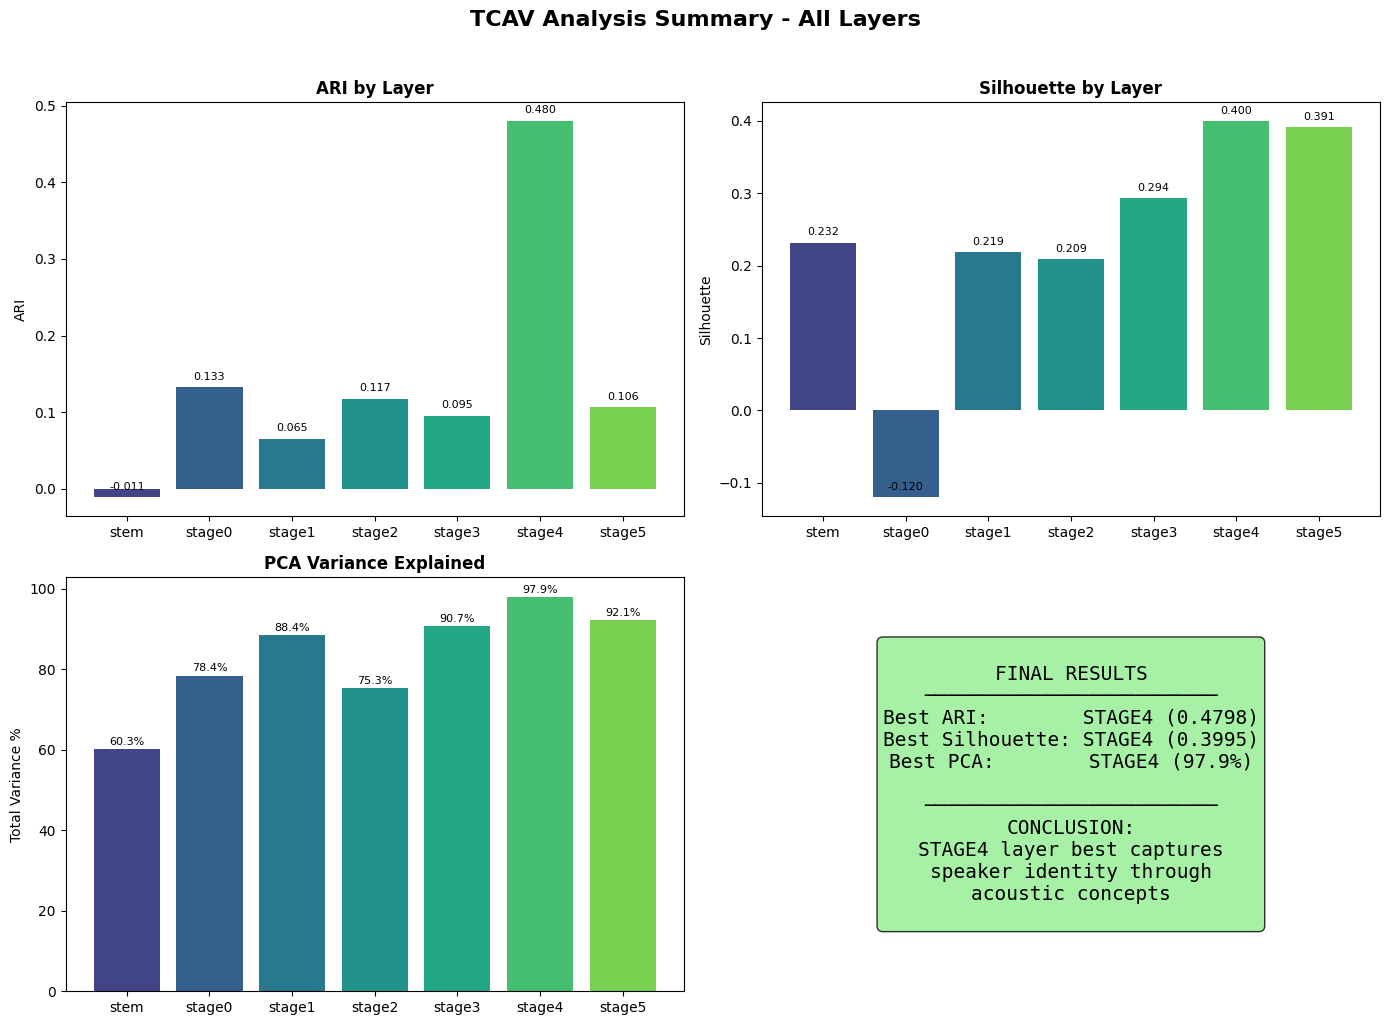


All plots saved to tcav/ folder!


In [16]:
# Save summary plot
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. ARI comparison
axes[0,0].bar(layers, ari_vals, color=colors)
axes[0,0].set_title('ARI by Layer', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('ARI')
for i, v in enumerate(ari_vals):
    axes[0,0].text(i, v+0.01, f'{v:.3f}', ha='center', fontsize=8)

# 2. Silhouette comparison
axes[0,1].bar(layers, sil_vals, color=colors)
axes[0,1].set_title('Silhouette by Layer', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Silhouette')
for i, v in enumerate(sil_vals):
    axes[0,1].text(i, v+0.01, f'{v:.3f}', ha='center', fontsize=8)

# 3. PCA variance
axes[1,0].bar(layers, pca_df['Total'], color=colors)
axes[1,0].set_title('PCA Variance Explained', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Total Variance %')
for i, v in enumerate(pca_df['Total']):
    axes[1,0].text(i, v+1, f'{v:.1f}%', ha='center', fontsize=8)

# 4. Summary text
axes[1,1].axis('off')
summary_text = f"""
FINAL RESULTS
─────────────────────────
Best ARI:        {best_ari_layer.upper()} ({best_ari:.4f})
Best Silhouette: {best_sil_layer.upper()} ({best_sil:.4f})
Best PCA:        {best_pca_layer.upper()} ({best_pca:.1f}%)

─────────────────────────
CONCLUSION:
{best_ari_layer.upper()} layer best captures
speaker identity through
acoustic concepts
"""
axes[1,1].text(0.5, 0.5, summary_text, transform=axes[1,1].transAxes,
               fontsize=14, verticalalignment='center', horizontalalignment='center',
               fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.suptitle('TCAV Analysis Summary - All Layers', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('tcav/final_summary.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nAll plots saved to tcav/ folder!")